In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RepeatedStratifiedKFold,cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, SCORERS, f1_score
from sklearn.metrics import classification_report, make_scorer, balanced_accuracy_score, RocCurveDisplay, PrecisionRecallDisplay
from sklearn import tree
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
import pickle
# from myfunctions_classification import*

In [2]:
# from importlib import reload
# import myfunctions
# reload(myfunctions)
# from myfunctions import* 

In [3]:
matplotlib_inline.backend_inline.set_matplotlib_formats('png', 'pdf')
plt.rcParams.update({'font.size': 12,
                     'xtick.labelsize' : 12,
                     'ytick.labelsize' : 12,
                     'axes.grid': False})
my_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
####### inserire questa riga di codice per salvare il decision tree in pdf #######
#graph.write_pdf("classtree_ex.pdf")

In [5]:
# measures

sorted(SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_we

In [6]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [7]:
# Positive Likelihood Ratio
def PLR(y_true, y_pred):
    tp, fn, fp, tn = confusion_matrix(y_true, y_pred, labels = [1,0]).reshape(-1,)
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    return tpr / fpr

#missclassification error
def ME(y_true, y_pred):
    tp, fn, fp, tn = confusion_matrix(y_true, y_pred, labels = [1,0]).reshape(-1,)
    return (fn + fp) / (tn + fp + fn + tp)

In [8]:
# score = make_scorer(PLR)
# score = make_scorer(ME, greater_is_better=False)
score = 'f1'

# Classification

Decision Tree:
- https://scikit-learn.org/stable/modules/tree.html (theory)
- https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn-tree-decisiontreeclassifier (algo)
- https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html#sklearn-tree-plot-tree (plot tree)

Tree visualization with graphviz:
- https://pydotplus.readthedocs.io/reference.html (pydotplus)
- https://github.com/carlos-jenkins/pydotplus (pydotplus)
- https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html#sklearn-tree-export-graphviz (plot tree)

Differenza tra le diverse modalità di visualizzazione del tree:
- https://mljar.com/blog/visualize-decision-tree/

Plot the decision surface of decision trees trained on the iris dataset:
- https://scikit-learn.org/stable/auto_examples/tree/plot_iris_dtc.html#plot-the-decision-surface-of-decision-trees-trained-on-the-iris-dataset

Model Evaluation:
- https://scikit-learn.org/stable/modules/grid_search.html#tuning-the-hyper-parameters-of-an-estimator (GridSearch)
- https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-evaluating-estimator-performance (Cross validation)

K-nearest neighbors: 
- https://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors (theory)
- https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn-neighbors-kneighborsclassifier (algo)

`GridSearchCV` accept different cross-validation generators. The default for binary or multiclass classification problems is `StratifiedKFold`. Otherwise, it uses `KFold`. It also accept `RepeatedKFold`, `RepeatedStratifiedKFold` and personalized ones.

In [9]:
# usiamo il df ante discretizzazioni a causa dell'implementazione di
# sklearn del decision tree classifier. Il decision tree non necessità
# che i dati siano prima normalizzati, tuttavia KNN sì, per cui di
# seguito si procede alla normalizzazione usando il min-max scaler
# forzando i valori in un range predefinito che va da 1 a 9 sia per
# il train che per il test set.

df = pd.read_pickle('df_filled.pkl')
attributes = [col for col in df.columns if col != 'POLY']
df[attributes] = MinMaxScaler(feature_range=(1, 9)).fit_transform(df[attributes].values)

In [10]:
df.describe().loc[['std', 'min', 'max']]

,LEN,ln(AROU),VAL,DOM,CNC,IMAG,FAM**3,AOA,SIZE,GEND,POLY,Log(FREQ)
std,1.146417,1.368515,1.674512,1.157909,2.163243,2.095481,1.718037,1.742378,1.47848,1.222298,0.272785,1.23363
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,0.000000,1.00000
max,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.00000,9.000000,1.000000,9.00000


In [11]:
# mettiamo la colonna POLY alla fine della tabella
df['POLY'], df['Log(FREQ)'] = df['Log(FREQ)'].values, df['POLY'].values
df.rename(columns={'POLY': 'Log(FREQ)', 'Log(FREQ)': 'POLY'}, inplace = True)

In [12]:
df

,LEN,ln(AROU),VAL,DOM,CNC,IMAG,FAM**3,AOA,SIZE,GEND,Log(FREQ),POLY
word,,,,,,,,,,,,
abattoir,4.428571,5.137949,2.926218,3.976050,6.762354,5.079939,1.219574,8.706537,5.734694,6.883102,2.689532,0
abbey,2.714286,3.424130,5.989891,4.391602,7.442852,6.544965,1.782886,6.504868,6.412317,4.085580,4.876573,0
abbreviate,5.571429,3.692363,5.432191,5.098289,3.489627,3.213682,4.150769,7.013908,2.866715,4.980573,2.600500,0
abdicate,4.428571,5.129662,3.874623,4.083048,3.611845,2.197540,2.411232,7.973574,5.773704,6.582984,2.519570,0
abdication,5.571429,4.627538,3.993304,4.557076,3.498680,2.282091,1.612466,8.215577,6.357414,5.784458,2.540868,0
...,...,...,...,...,...,...,...,...,...,...,...,...
zeppelin,4.428571,7.381549,5.169621,5.220218,8.016220,7.837817,1.662461,7.699583,6.907892,6.719645,4.689452,0
zero,2.142857,4.899875,4.310490,4.267185,2.587326,4.329746,6.870742,2.970793,1.553368,5.249874,6.202539,0
zest,2.142857,7.175487,7.079034,6.200622,5.227839,4.529593,2.444770,6.764951,2.821925,4.285212,3.631014,0


In [13]:
np.unique(df.POLY, return_counts = True)

(array([0, 1], dtype=int64), array([4303,  379], dtype=int64))

In [14]:
# cardinalità delle due classi

nclass_card = df.POLY.value_counts()[0]
pclass_card = df.POLY.value_counts()[1]
nclass_card, pclass_card

(4303, 379)

In [15]:
# distorsione della variabile target

skew = df.POLY.value_counts()[1] / df.POLY.shape[0]
print(f'skew = {skew:.2%}')

skew = 8.09%


In [16]:
# correlazioni degli attributi con la variabile target

df.corr()['POLY'].sort_values(ascending = False)

POLY         1.000000
Log(FREQ)    0.190886
CNC          0.113538
FAM**3       0.104411
IMAG         0.104248
DOM          0.052000
GEND         0.024727
VAL          0.020664
ln(AROU)    -0.084245
SIZE        -0.132842
AOA         -0.178988
LEN         -0.231101
Name: POLY, dtype: float64

# Partizionamento dati

In [17]:
X = df.values
y = df['POLY'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = 42)

In [18]:
X_train.shape, X_test.shape

((3277, 12), (1405, 12))

In [19]:
# datasets per effettuare undersampling

X_nopoly = X_train[X_train[:,-1] == 0]
X_sipoly = X_train[X_train[:,-1] == 1]

In [20]:
# elimino l'attributo POLY dal train e dal test set

X_train = X_train[:,:-1]
X_test = X_test[:,:-1]

In [21]:
X_train.shape, X_test.shape

((3277, 11), (1405, 11))

In [25]:
np.save('test_set_classification.npy', X_test) # save

In [26]:
np.save('y_test_set_classification.npy', y_test) # save

In [22]:
# maschere da usare per escludere le varaibili non PSY

attr_psico = [col for col in attributes if col not in ['Log(FREQ)','LEN'] ]
mask_attr_psico = [True if col not in ['Log(FREQ)','LEN'] else False for col in attributes]

In [23]:
# train e test senza le variabili non PSY

X_train_PSY = X_train[:,mask_attr_psico]
X_test_PSY = X_test[:,mask_attr_psico]

In [24]:
X_train_PSY.shape, X_test_PSY.shape

((3277, 9), (1405, 9))

# Decision Tree

## Repeated stratified cross validation without using sampling techniques

Repeats Stratified K-Fold n times with different randomization in each repetition.

In [429]:
param_list = {'max_depth': list(range(2,13)),
             'min_samples_split': [40,50,60,70,80],
             'min_samples_leaf': [30,40,50,60]
             }

In [430]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5)
clf = DecisionTreeClassifier()
grid_search = GridSearchCV(clf, param_grid=param_list, cv = cv, scoring=score)
grid_search.fit(X_train, y_train)

best_clf = grid_search.best_estimator_
best_clf

DecisionTreeClassifier(max_depth=11, min_samples_leaf=30, min_samples_split=50)

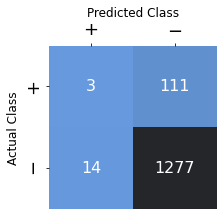

array([[   3,  111],
       [  14, 1277]], dtype=int64)

In [431]:
# testiamo il modello sul test set

plt.figure(figsize=(3,3))
y_pred = best_clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels = [1,0])
sns.heatmap(cm, annot = True, fmt='0', annot_kws={"fontsize":16}, 
            cmap= sns.dark_palette("#69d", reverse=True, as_cmap=True), cbar = False)
plt.xticks([0.5,1.5], [r'+', r'$-$'], fontsize = 18)
plt.yticks([0.5,1.5], [r'+', r'$-$'], fontsize = 18)
plt.xlabel('Predicted Class', fontsize = 12)
plt.ylabel('Actual Class', fontsize = 12)
ax = plt.gca()
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
# plt.savefig('DT_cm.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show()
cm

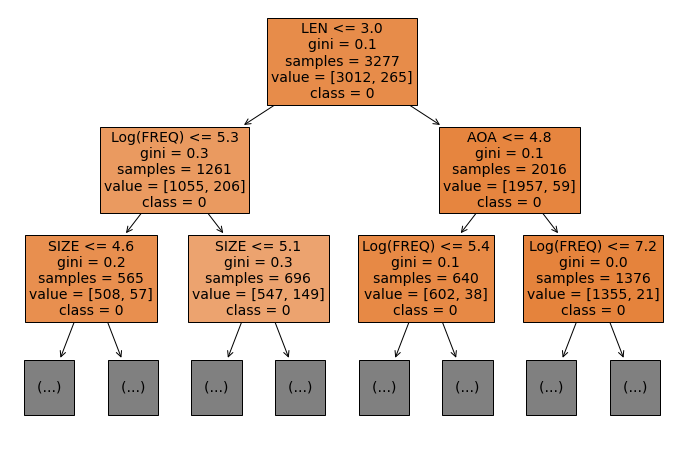

In [432]:
plt.figure(figsize = (12,8))
class_names = list(map(str, best_clf.classes_))
tree.plot_tree(best_clf, max_depth = 2, precision=1,feature_names = attributes, 
               filled = True, class_names = class_names, fontsize = 14)
plt.show()

In [433]:
print(' tree depth =', best_clf.get_depth(), '\n',
        'number of leaves = ', best_clf.get_n_leaves())

 tree depth = 10 
 number of leaves =  56


In [434]:
# performance on the test set
# the accuracy measure is not suitable for handling data sets with imbalanced class distributions 
# as it tends to favor classifiers that correctly classify the majority class

print('Balanced_Accuracy %s' % balanced_accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Balanced_Accuracy 0.5077357413673611
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      1291
           1       0.18      0.03      0.05       114

    accuracy                           0.91      1405
   macro avg       0.55      0.51      0.50      1405
weighted avg       0.86      0.91      0.88      1405



In [435]:
# performance on the train set

y_pred_train = best_clf.predict(X_train)
print('Balanced_Accuracy %s' % balanced_accuracy_score(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

Balanced_Accuracy 0.5735404294770603
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      3012
           1       0.64      0.15      0.25       265

    accuracy                           0.92      3277
   macro avg       0.79      0.57      0.60      3277
weighted avg       0.91      0.92      0.90      3277



In [436]:
res = grid_search.cv_results_
report(res, n_top=3)

Model with rank: 1
Mean validation score: 0.109 (std: 0.082)
Parameters: {'max_depth': 11, 'min_samples_leaf': 30, 'min_samples_split': 50}

Model with rank: 1
Mean validation score: 0.109 (std: 0.082)
Parameters: {'max_depth': 11, 'min_samples_leaf': 30, 'min_samples_split': 60}

Model with rank: 3
Mean validation score: 0.109 (std: 0.082)
Parameters: {'max_depth': 10, 'min_samples_leaf': 30, 'min_samples_split': 60}

Model with rank: 3
Mean validation score: 0.109 (std: 0.082)
Parameters: {'max_depth': 11, 'min_samples_leaf': 30, 'min_samples_split': 40}

Model with rank: 3
Mean validation score: 0.109 (std: 0.082)
Parameters: {'max_depth': 12, 'min_samples_leaf': 30, 'min_samples_split': 50}



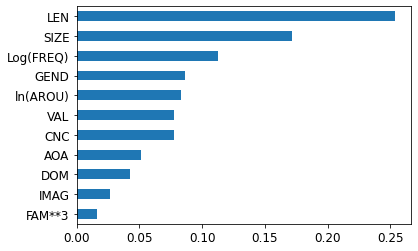

LEN          0.253935
SIZE         0.171323
Log(FREQ)    0.112237
GEND         0.086657
ln(AROU)     0.083268
VAL          0.077931
CNC          0.077632
AOA          0.051628
DOM          0.042530
IMAG         0.026673
FAM**3       0.016187
dtype: float64

In [437]:
best_attributes = pd.Series(best_clf.feature_importances_, index = attributes)
best_attributes = best_attributes.sort_values(ascending = True)
plt.figure(figsize=(6,4))
best_attributes.plot.barh()
plt.show()
best_attributes[::-1]

usando tutto il dataset, siccome la variabile target è skew, il modello riesce a predire i valori tp solo per bassi valori di `min_samples_leaf`

## Undersampling

In [29]:
X_nopoly.shape, X_sipoly.shape

((3012, 12), (265, 12))

In [30]:
# cardinalità delle due classi

n_nclass = X_nopoly.shape[0]
n_pclass = X_sipoly.shape[0]

n_nclass, n_pclass

(3012, 265)

In [31]:
# facciamo un random sample dei record della magority class
# così da equiparare la cardinalità delle due classi

idx = np.random.randint(n_nclass, size=n_pclass)
X_nopoly_samp = X_nopoly[idx, :]
X_nopoly_samp.shape

(265, 12)

In [32]:
# varianza della negative class prima e dopo il campionamento

var_X_nopoly = X_nopoly.var(axis = 0).round(2)
pd.DataFrame(var_X_nopoly.reshape(1,-1)[:, :-1], columns = attributes)

,LEN,ln(AROU),VAL,DOM,CNC,IMAG,FAM**3,AOA,SIZE,GEND,Log(FREQ)
0,1.32,1.86,2.99,1.4,4.74,4.41,2.98,3.0,2.17,1.55,1.52


In [33]:
var_X_nopoly_samp = X_nopoly_samp.var(axis = 0).round(2)
pd.DataFrame(var_X_nopoly_samp.reshape(1,-1)[:, :-1], columns = attributes)

,LEN,ln(AROU),VAL,DOM,CNC,IMAG,FAM**3,AOA,SIZE,GEND,Log(FREQ)
0,1.37,1.68,2.72,1.34,4.52,4.31,2.96,2.9,2.21,1.4,1.54


In [34]:
# ricomponiamo il dataset bilanciato

X_undersamp = np.vstack((X_nopoly_samp, X_sipoly))
np.random.shuffle(X_undersamp)

X_undersamp.shape

(530, 12)

In [35]:
# infine isoliamo la variabile target

X_train_undersamp = X_undersamp[:,:-1]
y_train_undersamp = X_undersamp[:,-1].astype(int)

X_train_undersamp.shape, y_train_undersamp.shape

((530, 11), (530,))

In [744]:
param_list = {'max_depth': [2,3,4,5,6,7,8],
             'min_samples_split': [40,50,60,70,80],
             'min_samples_leaf': [20,30,40,50,60]
             }

In [745]:
# k-fold cv model selection 

clf = DecisionTreeClassifier()
grid_search = GridSearchCV(clf, param_grid=param_list, cv = 5, scoring=score)
grid_search.fit(X_train_undersamp, y_train_undersamp)

best_clf = grid_search.best_estimator_
best_clf

DecisionTreeClassifier(max_depth=3, min_samples_leaf=20, min_samples_split=40)

In [746]:
print(' tree depth =', best_clf.get_depth(), '\n',
        'number of leaves = ', best_clf.get_n_leaves())

 tree depth = 3 
 number of leaves =  8


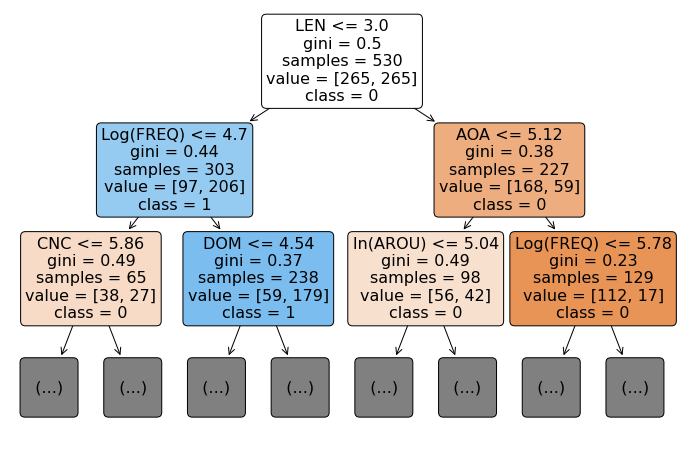

In [750]:
plt.figure(figsize = (12,8))
class_names = list(map(str, best_clf.classes_))
tree.plot_tree(best_clf, feature_names = attributes, precision=2,filled = True, 
               class_names = class_names, max_depth = 2, rounded=True, fontsize = 16)
plt.savefig('DT_under_tree.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show()

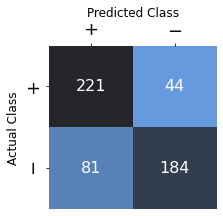

array([[221,  44],
       [ 81, 184]], dtype=int64)

In [748]:
# testiamo il modello sul train set usato per la sua costruzione

plt.figure(figsize=(3,3))
y_pred = best_clf.predict(X_train_undersamp)
cm = confusion_matrix(y_train_undersamp, y_pred, labels = [1,0])
sns.heatmap(cm, annot = True, fmt='0', annot_kws={"fontsize":16}, 
            cmap= sns.dark_palette("#69d", reverse=True, as_cmap=True), cbar = False)
plt.xticks([0.5,1.5], [r'+', r'$-$'], fontsize = 18)
plt.yticks([0.5,1.5], [r'+', r'$-$'], fontsize = 18)
plt.xlabel('Predicted Class', fontsize = 12)
plt.ylabel('Actual Class', fontsize = 12)
ax = plt.gca()
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
# plt.savefig('DT_under_cm.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show()
cm

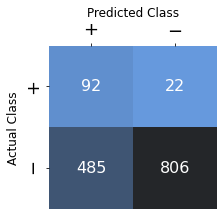

array([[ 92,  22],
       [485, 806]], dtype=int64)

In [749]:
# testiamo il modello sul test set 

plt.figure(figsize=(3,3))
y_pred = best_clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels = [1,0])
sns.heatmap(cm, annot = True, fmt='0', annot_kws={"fontsize":16}, 
            cmap= sns.dark_palette("#69d", reverse=True, as_cmap=True), cbar = False)
plt.xticks([0.5,1.5], [r'+', r'$-$'], fontsize = 18)
plt.yticks([0.5,1.5], [r'+', r'$-$'], fontsize = 18)
plt.xlabel('Predicted Class', fontsize = 12)
plt.ylabel('Actual Class', fontsize = 12)
ax = plt.gca()
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
plt.savefig('DT_under_cm.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show()
cm

In [751]:
# performance on the test set
# the accuracy measure is not suitable for handling data sets with imbalanced class distributions 
# as it tends to favor classifiers that correctly classify the majority class

print('Balanced_Accuracy %s' % balanced_accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Balanced_Accuracy 0.715669887344232
              precision    recall  f1-score   support

           0       0.97      0.62      0.76      1291
           1       0.16      0.81      0.27       114

    accuracy                           0.64      1405
   macro avg       0.57      0.72      0.51      1405
weighted avg       0.91      0.64      0.72      1405



In [1]:
# performance on the train set

y_pred_train = best_clf.predict(X_train_undersamp)
print('Balanced_Accuracy %s' % balanced_accuracy_score(y_train_undersamp, y_pred_train))
print(classification_report(y_train_undersamp, y_pred_train))

NameError: name 'best_clf' is not defined

In [753]:
res = grid_search.cv_results_
report(res, n_top=3)

Model with rank: 1
Mean validation score: 0.697 (std: 0.050)
Parameters: {'max_depth': 3, 'min_samples_leaf': 20, 'min_samples_split': 40}

Model with rank: 2
Mean validation score: 0.695 (std: 0.049)
Parameters: {'max_depth': 5, 'min_samples_leaf': 20, 'min_samples_split': 50}

Model with rank: 2
Mean validation score: 0.695 (std: 0.049)
Parameters: {'max_depth': 7, 'min_samples_leaf': 20, 'min_samples_split': 50}

Model with rank: 2
Mean validation score: 0.695 (std: 0.049)
Parameters: {'max_depth': 8, 'min_samples_leaf': 20, 'min_samples_split': 50}



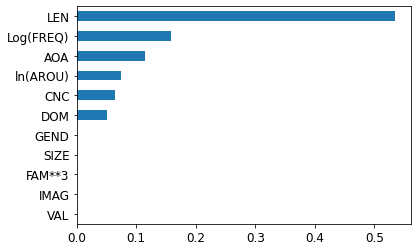

LEN          0.535280
Log(FREQ)    0.158947
AOA          0.114727
ln(AROU)     0.074503
CNC          0.064770
DOM          0.051773
GEND         0.000000
SIZE         0.000000
FAM**3       0.000000
IMAG         0.000000
VAL          0.000000
dtype: float64

In [754]:
best_attributes = pd.Series(best_clf.feature_importances_, index = attributes)
best_attributes = best_attributes.sort_values(ascending = True)
plt.figure(figsize=(6,4))
best_attributes.plot.barh()
plt.savefig('DT_under_barh.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show()
best_attributes[::-1]

In [755]:
# salva il modello ottenuto

with open('DT_under.pkl','wb') as f:
    pickle.dump(best_clf,f)


### Usiamo solo gli attributi psicolinguistici

In [362]:
attributes

['LEN',
 'ln(AROU)',
 'VAL',
 'DOM',
 'CNC',
 'IMAG',
 'FAM**3',
 'AOA',
 'SIZE',
 'GEND',
 'Log(FREQ)']

In [363]:
# utilizziamo gli stessi dati di prima ma eliminiamo gli attributi non PSY dal training e dal test set

X_train_undersamp = X_train_undersamp[:,mask_attr_psico]
# y_train = y_train_undersamp.copy() 

In [364]:
X_train_undersamp.shape, y_train_undersamp.shape

((530, 9), (530,))

In [365]:
# X_test = X_test[:,mask_attr_psico]
X_test_PSY.shape 

(1405, 9)

In [366]:
np.unique(y_train_undersamp, return_counts = True)

(array([0, 1]), array([265, 265], dtype=int64))

In [367]:
param_list = {#'max_depth': [None,2,3,4,5,6,7],
             'min_samples_split': [40,50,60,70,80],
             'min_samples_leaf': [20,30,40,50,60]
             }

In [368]:
clf = DecisionTreeClassifier()
grid_search = GridSearchCV(clf, param_grid=param_list, cv = 5, scoring=score)
grid_search.fit(X_train_undersamp, y_train_undersamp)

best_clf = grid_search.best_estimator_
best_clf

DecisionTreeClassifier(min_samples_leaf=20, min_samples_split=40)

In [369]:
 print(' tree depth =', best_clf.get_depth(), '\n',
        'number of leaves = ', best_clf.get_n_leaves())

 tree depth = 8 
 number of leaves =  20


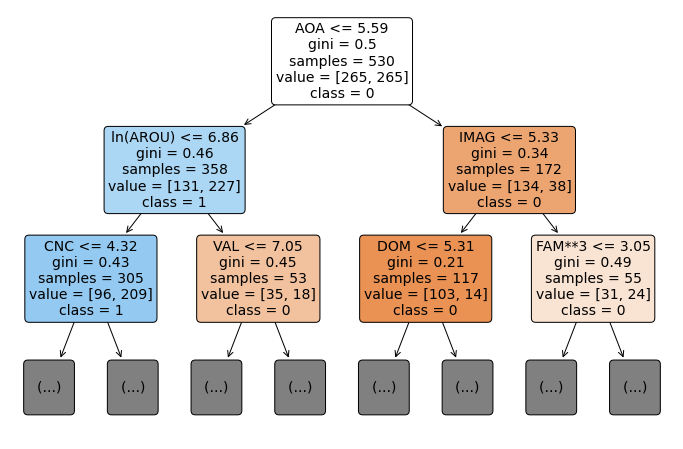

In [370]:
plt.figure(figsize = (12,8))
class_names = list(map(str, best_clf.classes_))
tree.plot_tree(best_clf, feature_names = attr_psico, max_depth=2, precision=2,filled = True, 
               class_names = class_names, rounded=True, fontsize = 14)
plt.show()

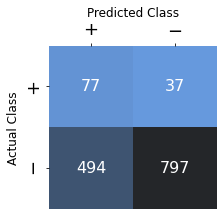

array([[ 77,  37],
       [494, 797]], dtype=int64)

In [371]:
# testiamo il modello sul test set 

plt.figure(figsize=(3,3))
y_pred = best_clf.predict(X_test_PSY)
cm = confusion_matrix(y_test, y_pred, labels = [1,0])
sns.heatmap(cm, annot = True, fmt='0', annot_kws={"fontsize":16}, 
            cmap= sns.dark_palette("#69d", reverse=True, as_cmap=True), cbar = False)
plt.xticks([0.5,1.5], [r'+', r'$-$'], fontsize = 18)
plt.yticks([0.5,1.5], [r'+', r'$-$'], fontsize = 18)
plt.xlabel('Predicted Class', fontsize = 12)
plt.ylabel('Actual Class', fontsize = 12)
ax = plt.gca()
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
# plt.savefig('DT_under_cm_psico.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show()
cm

In [372]:
# performance on the test set
# the accuracy measure is not suitable for handling data sets with imbalanced class distributions 
# as it tends to favor classifiers that correctly classify the majority class

print('Balanced_Accuracy %s'  % balanced_accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Balanced_Accuracy 0.6463947436367836
              precision    recall  f1-score   support

           0       0.96      0.62      0.75      1291
           1       0.13      0.68      0.22       114

    accuracy                           0.62      1405
   macro avg       0.55      0.65      0.49      1405
weighted avg       0.89      0.62      0.71      1405



In [373]:
# performance on the train set

y_pred_train = best_clf.predict(X_train_undersamp)
print('Accuracy %s' % accuracy_score(y_train_undersamp, y_pred_train))
print(classification_report(y_train_undersamp, y_pred_train))

Accuracy 0.7509433962264151
              precision    recall  f1-score   support

           0       0.75      0.76      0.75       265
           1       0.76      0.74      0.75       265

    accuracy                           0.75       530
   macro avg       0.75      0.75      0.75       530
weighted avg       0.75      0.75      0.75       530



In [374]:
res = grid_search.cv_results_
report(res, n_top=3)

Model with rank: 1
Mean validation score: 0.679 (std: 0.049)
Parameters: {'min_samples_leaf': 20, 'min_samples_split': 40}

Model with rank: 2
Mean validation score: 0.675 (std: 0.058)
Parameters: {'min_samples_leaf': 50, 'min_samples_split': 40}

Model with rank: 2
Mean validation score: 0.675 (std: 0.058)
Parameters: {'min_samples_leaf': 50, 'min_samples_split': 50}

Model with rank: 2
Mean validation score: 0.675 (std: 0.058)
Parameters: {'min_samples_leaf': 50, 'min_samples_split': 60}

Model with rank: 2
Mean validation score: 0.675 (std: 0.058)
Parameters: {'min_samples_leaf': 50, 'min_samples_split': 70}

Model with rank: 2
Mean validation score: 0.675 (std: 0.058)
Parameters: {'min_samples_leaf': 50, 'min_samples_split': 80}



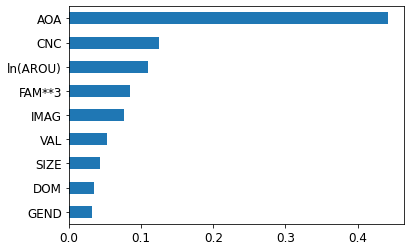

AOA         0.441864
CNC         0.125285
ln(AROU)    0.109414
FAM**3      0.084808
IMAG        0.076121
VAL         0.052944
SIZE        0.042802
DOM         0.035299
GEND        0.031462
dtype: float64

In [375]:
best_attributes = pd.Series(best_clf.feature_importances_, index = attr_psico)
best_attributes = best_attributes.sort_values(ascending = True)
plt.figure(figsize=(6,4))
best_attributes.plot.barh()
plt.show()
best_attributes[::-1]

## SMOTE (Oversampling)

In [42]:
X_train.shape, X_test.shape

((3277, 11), (1405, 11))

In [43]:
np.unique(y_train, return_counts = True)

(array([0, 1], dtype=int64), array([3012,  265], dtype=int64))

La SMOTE, per ogni record appartenente alla classe positiva, crea 3012/265  nuovi record artificiali dati dalla combinazione lineare convessa tra il record considerato e uno a caso dei k-neighbor più vicini.

In [44]:
sm = SMOTE(k_neighbors=5, random_state=31) 
X_res, y_res = sm.fit_resample(X_train, y_train)

In [45]:
X_res.shape, y_res.shape

((6024, 11), (6024,))

In [380]:
np.unique(y_res, return_counts = True)

(array([0, 1], dtype=int64), array([3012, 3012], dtype=int64))

In [381]:
param_list = {'max_depth': [2,3,4,5,6,7,8,9,10],
             'min_samples_split': [60,70,80,90,100],
             'min_samples_leaf': [30,40,50,60,70,80]
             }

In [382]:
clf = DecisionTreeClassifier()
grid_search = GridSearchCV(clf, param_grid=param_list, cv = 10, scoring=score)
grid_search.fit(X_res, y_res)

best_clf = grid_search.best_estimator_
best_clf

DecisionTreeClassifier(max_depth=10, min_samples_leaf=30, min_samples_split=70)

In [383]:
print(' tree depth =', best_clf.get_depth(), '\n',
        'number of leaves = ', best_clf.get_n_leaves())

 tree depth = 10 
 number of leaves =  74


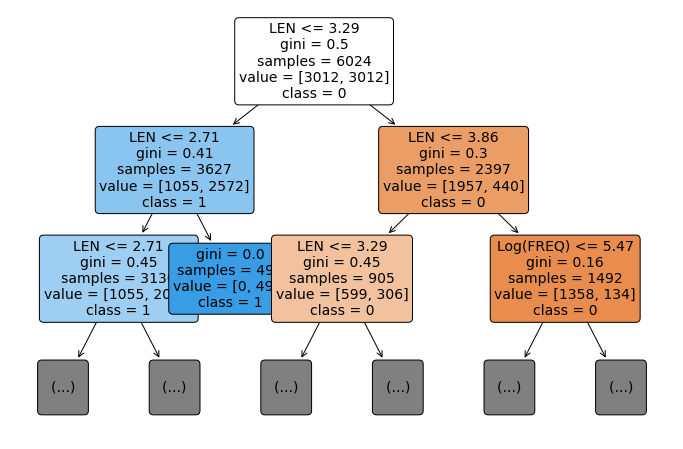

In [384]:
plt.figure(figsize = (12,8))
class_names = list(map(str, best_clf.classes_))
tree.plot_tree(best_clf, feature_names = attributes,max_depth=2, precision=2,filled = True, 
               class_names = class_names, rounded=True, fontsize = 14)
plt.show()

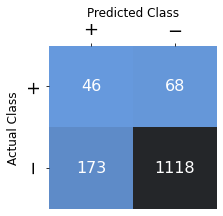

array([[  46,   68],
       [ 173, 1118]], dtype=int64)

In [385]:
plt.figure(figsize=(3,3))
y_pred = best_clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels = [1,0])
sns.heatmap(cm, annot = True, fmt='0', annot_kws={"fontsize":16}, 
            cmap= sns.dark_palette("#69d", reverse=True, as_cmap=True), cbar = False)
plt.xticks([0.5,1.5], [r'+', r'$-$'], fontsize = 18)
plt.yticks([0.5,1.5], [r'+', r'$-$'], fontsize = 18)
plt.xlabel('Predicted Class', fontsize = 12)
plt.ylabel('Actual Class', fontsize = 12)
ax = plt.gca()
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
plt.savefig('DT_SMOTE_cm.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show()
cm

In [386]:
# performance on the test set
# the accuracy measure is not suitable for handling data sets with imbalanced class distributions 
# as it tends to favor classifiers that correctly classify the majority class

print('Balanced_Accuracy %s' % balanced_accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Balanced_Accuracy 0.6347520621848968
F1-score [0.90270488 0.27627628]
              precision    recall  f1-score   support

           0       0.94      0.87      0.90      1291
           1       0.21      0.40      0.28       114

    accuracy                           0.83      1405
   macro avg       0.58      0.63      0.59      1405
weighted avg       0.88      0.83      0.85      1405



In [387]:
# performance on the train set

y_pred_train = best_clf.predict(X_res)
print('Accuracy %s' % accuracy_score(y_res, y_pred_train))
print('F1-score %s' % f1_score(y_res, y_pred_train, average=None))
print(classification_report(y_res, y_pred_train))

Accuracy 0.8897742363877822
F1-score [0.89013898 0.88940706]
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      3012
           1       0.89      0.89      0.89      3012

    accuracy                           0.89      6024
   macro avg       0.89      0.89      0.89      6024
weighted avg       0.89      0.89      0.89      6024



In [388]:
res = grid_search.cv_results_
report(res, n_top=3)

Model with rank: 1
Mean validation score: 0.852 (std: 0.070)
Parameters: {'max_depth': 10, 'min_samples_leaf': 30, 'min_samples_split': 70}

Model with rank: 2
Mean validation score: 0.850 (std: 0.075)
Parameters: {'max_depth': 10, 'min_samples_leaf': 30, 'min_samples_split': 60}

Model with rank: 3
Mean validation score: 0.849 (std: 0.086)
Parameters: {'max_depth': 10, 'min_samples_leaf': 30, 'min_samples_split': 90}



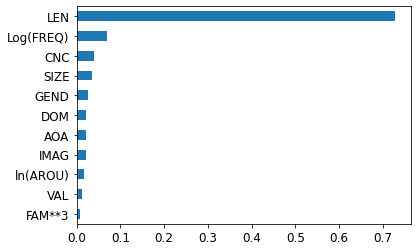

LEN          0.728375
Log(FREQ)    0.068852
CNC          0.040156
SIZE         0.035484
GEND         0.026078
DOM          0.022434
AOA          0.021788
IMAG         0.020592
ln(AROU)     0.016362
VAL          0.012502
FAM**3       0.007377
dtype: float64

In [389]:
best_attributes = pd.Series(best_clf.feature_importances_, index = attributes)
best_attributes = best_attributes.sort_values(ascending = True)
plt.figure(figsize=(6,4))
best_attributes.plot.barh()
plt.show()
best_attributes[::-1]

In [390]:
with open('DT_SMOTE.pkl','wb') as f:
    pickle.dump(best_clf,f)


### Usiamo solo gli attributi psicolinguistici

In [391]:
X_train_PSY.shape, X_test_PSY.shape

((3277, 9), (1405, 9))

In [392]:
np.unique(y_train, return_counts = True)

(array([0, 1], dtype=int64), array([3012,  265], dtype=int64))

La SMOTE, per ogni record appartenente alla classe positiva, crea 3012/265  nuovi record artificiali dati dalla combinazione lineare convessa tra il record considerato e uno a caso dei k-neighbor più vicini.

In [393]:
sm = SMOTE(k_neighbors=5,random_state=69) 
X_res, y_res = sm.fit_resample(X_train_PSY, y_train)

In [394]:
X_res.shape, y_res.shape

((6024, 9), (6024,))

In [395]:
np.unique(y_res, return_counts = True)

(array([0, 1], dtype=int64), array([3012, 3012], dtype=int64))

In [396]:
param_list = {'max_depth': [2,3,4,5,6,7,8,9,10],
             'min_samples_split': [40,50,60,70,80],
             'min_samples_leaf': [20,30,40,50,60]
             }

In [397]:
clf = DecisionTreeClassifier()
grid_search = GridSearchCV(clf, param_grid=param_list, cv = 10, scoring=score)
grid_search.fit(X_res, y_res)

best_clf = grid_search.best_estimator_
best_clf

DecisionTreeClassifier(max_depth=10, min_samples_leaf=20, min_samples_split=40)

In [398]:
print(' tree depth =', best_clf.get_depth(), '\n',
        'number of leaves = ', best_clf.get_n_leaves())

 tree depth = 10 
 number of leaves =  110


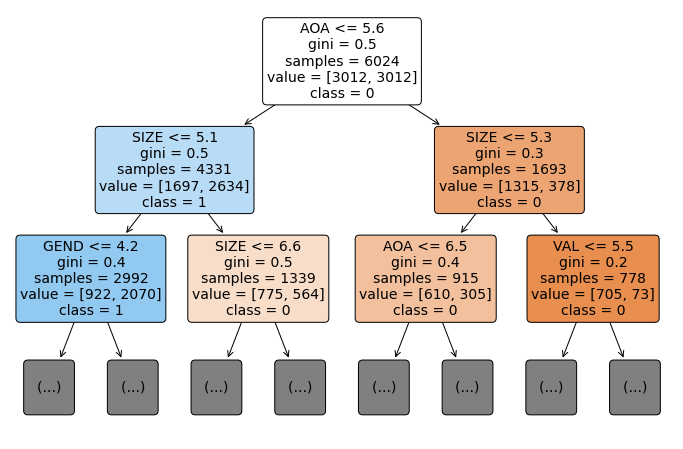

In [399]:
plt.figure(figsize = (12,8))
class_names = list(map(str, best_clf.classes_))
tree.plot_tree(best_clf, feature_names = attr_psico, max_depth=2, precision=1, filled = True, 
               class_names = class_names, rounded=True, fontsize = 14)
plt.show()

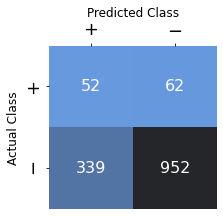

array([[ 52,  62],
       [339, 952]], dtype=int64)

In [400]:
plt.figure(figsize=(3,3))
y_pred = best_clf.predict(X_test_PSY)
cm = confusion_matrix(y_test, y_pred, labels = [1,0])
sns.heatmap(cm, annot = True, fmt='0', annot_kws={"fontsize":16}, 
            cmap= sns.dark_palette("#69d", reverse=True, as_cmap=True), cbar = False)
plt.xticks([0.5,1.5], [r'+', r'$-$'], fontsize = 18)
plt.yticks([0.5,1.5], [r'+', r'$-$'], fontsize = 18)
plt.xlabel('Predicted Class', fontsize = 12)
plt.ylabel('Actual Class', fontsize = 12)
ax = plt.gca()
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
# plt.savefig('DT_SMOTE_cm_PSY.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show()
cm

In [401]:
# performance on the test set

print('Balanced Accuracy %s' % balanced_accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Balanced Accuracy 0.5967766045633061
              precision    recall  f1-score   support

           0       0.94      0.74      0.83      1291
           1       0.13      0.46      0.21       114

    accuracy                           0.71      1405
   macro avg       0.54      0.60      0.52      1405
weighted avg       0.87      0.71      0.78      1405



In [402]:
# performance on the train set

y_pred_train = best_clf.predict(X_res)
print('Balanced Accuracy %s' % balanced_accuracy_score(y_res, y_pred_train))
print(classification_report(y_res, y_pred_train))

Balanced Accuracy 0.8414674634794157
              precision    recall  f1-score   support

           0       0.88      0.79      0.83      3012
           1       0.81      0.90      0.85      3012

    accuracy                           0.84      6024
   macro avg       0.85      0.84      0.84      6024
weighted avg       0.85      0.84      0.84      6024



In [403]:
res = grid_search.cv_results_
report(res, n_top=3)

Model with rank: 1
Mean validation score: 0.801 (std: 0.020)
Parameters: {'max_depth': 10, 'min_samples_leaf': 20, 'min_samples_split': 40}

Model with rank: 2
Mean validation score: 0.801 (std: 0.018)
Parameters: {'max_depth': 9, 'min_samples_leaf': 20, 'min_samples_split': 40}

Model with rank: 3
Mean validation score: 0.796 (std: 0.020)
Parameters: {'max_depth': 10, 'min_samples_leaf': 20, 'min_samples_split': 50}



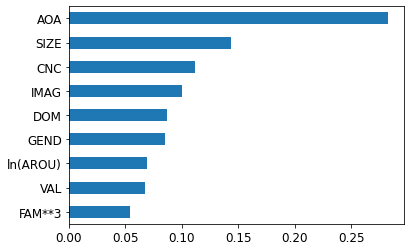

AOA         0.282333
SIZE        0.143542
CNC         0.111708
IMAG        0.100143
DOM         0.086480
GEND        0.085075
ln(AROU)    0.069348
VAL         0.067518
FAM**3      0.053854
dtype: float64

In [404]:
best_attributes = pd.Series(best_clf.feature_importances_, index = attr_psico)
best_attributes = best_attributes.sort_values(ascending = True)
plt.figure(figsize=(6,4))
best_attributes.plot.barh()
plt.show()
best_attributes[::-1]

# KNN

In [27]:
clf = KNeighborsClassifier(weights='distance')
param_list = {'n_neighbors': list(range(3,10))}
grid_search = GridSearchCV(clf, param_grid=param_list, cv = 10, scoring=score)
grid_search.fit(X_train, y_train)

best_clf = grid_search.best_estimator_
best_clf 

KNeighborsClassifier(n_neighbors=3, weights='distance')

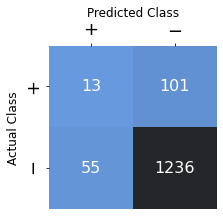

array([[  13,  101],
       [  55, 1236]], dtype=int64)

In [28]:
plt.figure(figsize=(3,3))
y_pred = best_clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels = [1,0])
sns.heatmap(cm, annot = True, fmt='0', annot_kws={"fontsize":16}, 
            cmap= sns.dark_palette("#69d", reverse=True, as_cmap=True), cbar = False)
plt.xticks([0.5,1.5], [r'+', r'$-$'], fontsize = 18)
plt.yticks([0.5,1.5], [r'+', r'$-$'], fontsize = 18)
plt.xlabel('Predicted Class', fontsize = 12)
plt.ylabel('Actual Class', fontsize = 12)
ax = plt.gca()
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
plt.savefig('KNN.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show()
cm

In [407]:
# performance on the test set

print('Balanced_Accuracy %s' % balanced_accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Balanced_Accuracy 0.5357162270509737
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      1291
           1       0.19      0.11      0.14       114

    accuracy                           0.89      1405
   macro avg       0.56      0.54      0.54      1405
weighted avg       0.86      0.89      0.88      1405



In [408]:
# performance on the train set

y_pred_train = best_clf.predict(X_train)
print('Balanced_Accuracy %s' % balanced_accuracy_score(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

Balanced_Accuracy 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3012
           1       1.00      1.00      1.00       265

    accuracy                           1.00      3277
   macro avg       1.00      1.00      1.00      3277
weighted avg       1.00      1.00      1.00      3277



In [409]:
# with open('KNN.pkl','wb') as f:
#     pickle.dump(best_clf,f)


## KNN undesampling

In [48]:
clf = KNeighborsClassifier(weights='distance')
param_list = {'n_neighbors': list(range(3,10))}
grid_search = GridSearchCV(clf, param_grid=param_list, cv = 10, scoring=score)
grid_search.fit(X_train_undersamp, y_train_undersamp)

best_clf = grid_search.best_estimator_
best_clf 

KNeighborsClassifier(n_neighbors=9, weights='distance')

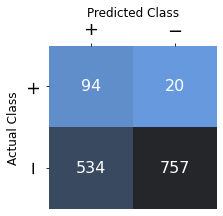

array([[ 94,  20],
       [534, 757]], dtype=int64)

In [49]:
plt.figure(figsize=(3,3))
y_pred = best_clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels = [1,0])
sns.heatmap(cm, annot = True, fmt='0', annot_kws={"fontsize":16}, 
            cmap= sns.dark_palette("#69d", reverse=True, as_cmap=True), cbar = False)
plt.xticks([0.5,1.5], [r'+', r'$-$'], fontsize = 18)
plt.yticks([0.5,1.5], [r'+', r'$-$'], fontsize = 18)
plt.xlabel('Predicted Class', fontsize = 12)
plt.ylabel('Actual Class', fontsize = 12)
ax = plt.gca()
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
# plt.savefig('KNN.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show()
cm

In [50]:
# with open('KNN_under.pkl','wb') as f:
#     pickle.dump(best_clf,f)


## KNN SMOTE

In [51]:
clf = KNeighborsClassifier(weights='distance')
param_list = {'n_neighbors': list(range(3,10))}
grid_search = GridSearchCV(clf, param_grid=param_list, cv = 10, scoring=score)
grid_search.fit(X_res, y_res)

best_clf = grid_search.best_estimator_
best_clf

KNeighborsClassifier(n_neighbors=4, weights='distance')

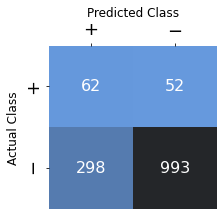

array([[ 62,  52],
       [298, 993]], dtype=int64)

In [52]:
plt.figure(figsize=(3,3))
y_pred = best_clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels = [1,0])
sns.heatmap(cm, annot = True, fmt='0', annot_kws={"fontsize":16}, 
            cmap= sns.dark_palette("#69d", reverse=True, as_cmap=True), cbar = False)
plt.xticks([0.5,1.5], [r'+', r'$-$'], fontsize = 18)
plt.yticks([0.5,1.5], [r'+', r'$-$'], fontsize = 18)
plt.xlabel('Predicted Class', fontsize = 12)
plt.ylabel('Actual Class', fontsize = 12)
ax = plt.gca()
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
# plt.savefig('KNN.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show()
cm

In [53]:
# with open('KNN_SMOTE.pkl','wb') as f:
#     pickle.dump(best_clf,f)


## Dummy classifiers

In [410]:
# a dummy classifier that always predicts negative

dummy_clf = DummyClassifier(strategy='constant', constant=0)
dummy_clf.fit(X_test, y_test)

DummyClassifier(constant=0, strategy='constant')

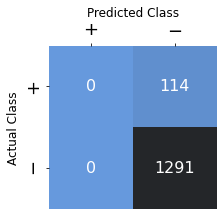

array([[   0,  114],
       [   0, 1291]], dtype=int64)

In [411]:
plt.figure(figsize=(3,3))
y_pred = dummy_clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels = [1,0])
sns.heatmap(cm, annot = True, fmt='0', annot_kws={"fontsize":16}, 
            cmap= sns.dark_palette("#69d", reverse=True, as_cmap=True), cbar = False)
plt.xticks([0.5,1.5], [r'+', r'$-$'], fontsize = 18)
plt.yticks([0.5,1.5], [r'+', r'$-$'], fontsize = 18)
plt.xlabel('Predicted Class', fontsize = 12)
plt.ylabel('Actual Class', fontsize = 12)
ax = plt.gca()
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
# plt.savefig('DT_under_cm.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show()
cm

In [412]:
# a dummy classifier that always predicts positive

dummy_clf = DummyClassifier(strategy='constant', constant=1)
dummy_clf.fit(X_test, y_test)

DummyClassifier(constant=1, strategy='constant')

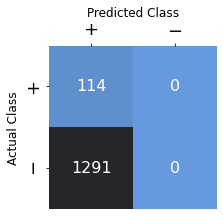

array([[ 114,    0],
       [1291,    0]], dtype=int64)

In [413]:
plt.figure(figsize=(3,3))
y_pred = dummy_clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels = [1,0])
sns.heatmap(cm, annot = True, fmt='0', annot_kws={"fontsize":16}, 
            cmap= sns.dark_palette("#69d", reverse=True, as_cmap=True), cbar = False)
plt.xticks([0.5,1.5], [r'+', r'$-$'], fontsize = 18)
plt.yticks([0.5,1.5], [r'+', r'$-$'], fontsize = 18)
plt.xlabel('Predicted Class', fontsize = 12)
plt.ylabel('Actual Class', fontsize = 12)
ax = plt.gca()
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
# plt.savefig('DT_under_cm.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show()
cm

In [414]:
# a dummy classifier that makes random predictions

dummy_clf = DummyClassifier(strategy='uniform')
dummy_clf.fit(X_test, y_test)

DummyClassifier(strategy='uniform')

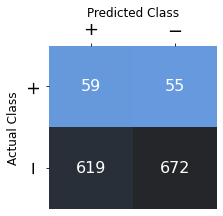

array([[ 59,  55],
       [619, 672]], dtype=int64)

In [415]:
plt.figure(figsize=(3,3))
y_pred = dummy_clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels = [1,0])
sns.heatmap(cm, annot = True, fmt='0', annot_kws={"fontsize":16}, 
            cmap= sns.dark_palette("#69d", reverse=True, as_cmap=True), cbar = False)
plt.xticks([0.5,1.5], [r'+', r'$-$'], fontsize = 18)
plt.yticks([0.5,1.5], [r'+', r'$-$'], fontsize = 18)
plt.xlabel('Predicted Class', fontsize = 12)
plt.ylabel('Actual Class', fontsize = 12)
ax = plt.gca()
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.show()
cm

# Model comparisons

In [55]:
# load models

with open('DT_under.pkl', 'rb') as f:
    DT_under = pickle.load(f)   

In [417]:
DT_under.get_params(), f'depth = {DT_under.get_depth()}', f'n_leaves = {DT_under.get_n_leaves()}'

({'ccp_alpha': 0.0,
  'class_weight': None,
  'criterion': 'gini',
  'max_depth': 4,
  'max_features': None,
  'max_leaf_nodes': None,
  'min_impurity_decrease': 0.0,
  'min_samples_leaf': 20,
  'min_samples_split': 40,
  'min_weight_fraction_leaf': 0.0,
  'random_state': None,
  'splitter': 'best'},
 'depth = 4',
 'n_leaves = 12')

In [418]:
with open('DT_SMOTE.pkl', 'rb') as f:
    DT_SMOTE = pickle.load(f)

In [419]:
DT_SMOTE.get_params(), f'depth = {DT_SMOTE.get_depth()}', f'n_leaves = {DT_SMOTE.get_n_leaves()}'

({'ccp_alpha': 0.0,
  'class_weight': None,
  'criterion': 'gini',
  'max_depth': 10,
  'max_features': None,
  'max_leaf_nodes': None,
  'min_impurity_decrease': 0.0,
  'min_samples_leaf': 30,
  'min_samples_split': 70,
  'min_weight_fraction_leaf': 0.0,
  'random_state': None,
  'splitter': 'best'},
 'depth = 10',
 'n_leaves = 74')

In [420]:
with open('KNN.pkl', 'rb') as f:
    KNN = pickle.load(f)

In [421]:
KNN.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 3,
 'p': 2,
 'weights': 'distance'}

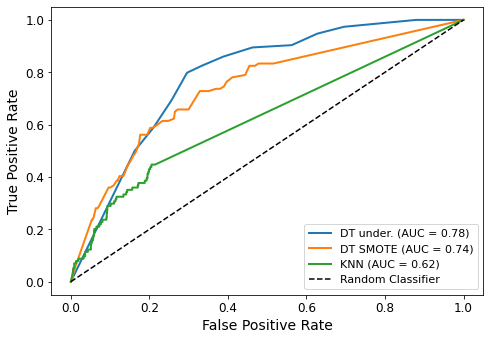

In [427]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_axes([0,0,1,1])
DT_under_disp = RocCurveDisplay.from_estimator(DT_under, X_test, y_test, ax = ax, name = 'DT under.', lw = 2)
DT_SMOTE_disp = RocCurveDisplay.from_estimator(DT_SMOTE, X_test, y_test, ax = ax, name = 'DT SMOTE', lw = 2)
KNN_disp = RocCurveDisplay.from_estimator(KNN, X_test, y_test, ax = ax, name = 'KNN', lw = 2)
rand = ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), 'k--', label = 'Random Classifier')
ax.set_ylabel('True Positive Rate', fontsize = 14)
ax.set_xlabel('False Positive Rate', fontsize = 14)
ax.legend(fontsize = '11')
plt.savefig('roc.pdf', format ='pdf', bbox_inches = 'tight')
plt.show()

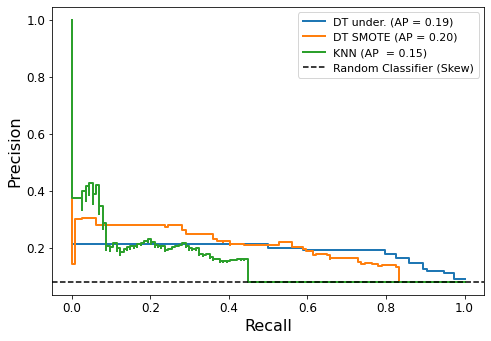

In [428]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_axes([0,0,1,1])
DT_under_disp = PrecisionRecallDisplay.from_estimator(DT_under, X_test, y_test, ax = ax, label = 'DT under. (AP = 0.19)', lw = 2)
DT_SMOTE_disp = PrecisionRecallDisplay.from_estimator(DT_SMOTE, X_test, y_test, ax = ax, label = 'DT SMOTE (AP = 0.20)', lw = 2)
KNN_disp = PrecisionRecallDisplay.from_estimator(KNN, X_test, y_test, ax = ax, label = 'KNN (AP  = 0.15)', lw = 2)
plt.axhline(y = (y_test.sum() / y_test.size), ls = '--', color = 'k', label = 'Random Classifier (Skew)')
ax.legend(fontsize = '11')
ax.set_ylabel('Precision', fontsize = 16)
ax.set_xlabel('Recall', fontsize = 16)
plt.savefig('precision_recall.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show()

In [59]:
print(attributes)

['LEN', 'ln(AROU)', 'VAL', 'DOM', 'CNC', 'IMAG', 'FAM**3', 'AOA', 'SIZE', 'GEND', 'Log(FREQ)']


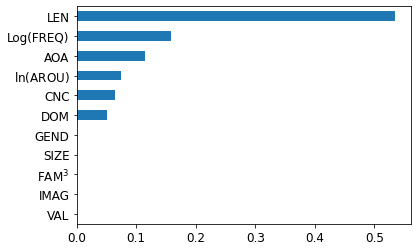

LEN                     0.535280
Log(FREQ)               0.158947
AOA                     0.114727
$\ln(\mathrm{AROU})$    0.074503
CNC                     0.064770
DOM                     0.051773
GEND                    0.000000
SIZE                    0.000000
$\mathrm{FAM}^3$        0.000000
IMAG                    0.000000
VAL                     0.000000
dtype: float64

In [60]:
attr = ['LEN', '$\ln(\mathrm{AROU})$', 'VAL', 'DOM', 'CNC', 'IMAG', '$\mathrm{FAM}^3$', 'AOA', 'SIZE', 'GEND', 'Log(FREQ)']
best_attributes = pd.Series(DT_under.feature_importances_, index = attr)
best_attributes = best_attributes.sort_values(ascending = True)
plt.figure(figsize=(6,4))
best_attributes.plot.barh()
plt.savefig('DT_under_barh.pdf', format = 'pdf', bbox_inches = 'tight')
plt.show()
best_attributes[::-1]